# Notes to self and to-do's
- Use python glob to look through all dir's when computing sigma for defect set + read in and count species
- Use above to help write script to extract coords of defect in perfect host
- Print min distances of defect from supercell boundaries to user
- Re-read CoFFEE docs to check if steps were missed for creating in_V file and use this to test with Tong's plotting script

----------------------------------------------------------


# Finite-size corrections to charged defect supercells with FHI-aims
This notebook is designed for applying finite-size corrections to charged defect supercells using outputs from the [FHI-aims](https://aimsclub.fhi-berlin.mpg.de/) electronic structure software package and the FNV correction scheme (doi: 10.1103/PhysRevLett.102.016402) through integration with the CoFFEE python code.

First download and install CoFFEE from [here](https://www.sciencedirect.com/science/article/pii/S0010465518300158).

The steps below are designed to allow for easier and consistent processing of large sets of defect calculations. 
All user defined settings are in the first cell. All subsequent cells do not require user inputs. They just need to be run in order and there is an explanation of the analysis being performed before each cell. Each charged defect still needs to be processed one at a time by specifying the location of directories with the relevant data in the 'User inputs' cell. The user must then extract the correction energy from the potential alignment plot at the end of this notebook.

### Assumptions made during the processing
1. The user is using python3 and has successfully installed the CoFFEE package and its dependencies
2. The electronic and ionic components of the host crystal have already been computed by the user
3. All defects are intrinsic defects (there are no atom types present in the defect supercell that are not also present in the perfect supercell)
4. The volume of the supercells has not been relaxed so lattice vectors are the same for the perfect and defect supercells (this is appropriate for simulating defects in the dilute limit)
5. The supercells have orthogonal axes for the lattice vectors (some numerical noise in the off-diagonals is okay)
6. A maximum of one point defect is present in each supercell
7. All filenames for FHI-aims calculations still have their original default names: 'geometry.in' and 'plane_average_realspace_ESP.out'
8. The data from all final one-shot calculations of the perfect and defect supercells are stored in one directory (one-shot meaning no relaxation steps were performed on the final structure so the only geometry files are 'geometry.in' and this corresponds to the final relaxed structures). Sub-directories within this directory are fine and are to be expected to keep data organised!
9. The same sigma value is used for the charge model for all defects in the same set for consistency, but note that in reality the charge associated with some defects may be more or less disperse

## 1. User inputs

In [1]:
# Dielectric properties of host crystal: electronic+ionic dielectric constants
dielectric_xx = 7.49 
dielectric_yy = 6.92
dielectric_zz = 7.19

# Location of CoFFEE code (this is the directory containing coffee.py and other Utilities of the CoFFEE package)
path_to_coffee_dir= '/Users/suzy/Desktop/DefectAnalysis/CoFFEE_1.1'
# Dir with all data for final one-shots of all defect supercells (inc. perfect supercell)
path_to_all_defects = '/Users/suzy/Desktop/DefectAnalysis/EnargiteDefects/fromLandau/Results/data/final_one_shots' 
# Dir with data for perfect host supercell
path_to_host = '/Users/suzy/Desktop/DefectAnalysis/EnargiteDefects/fromLandau/Results/data/final_one_shots/PerfectReference' 
# Dir with defect you want to perform correction for
path_to_defect = '/Users/suzy/Desktop/DefectAnalysis/EnargiteDefects/fromLandau/Results/data/final_one_shots/VacancySupercells/V-S/charged/+1/DefectSpacegroup1'
# Dir with neutral version of defect you want to correct
path_to_neutral = '/Users/suzy/Desktop/DefectAnalysis/EnargiteDefects/fromLandau/Results/data/final_one_shots/VacancySupercells/V-S/neutral/DefectSpacegroup1'
# Enter charge state of defect you want to perform the correction for
defect_charge = 1

# Choose names for files for outputs for correction steps
charge_model_file = 'cm_V_S_q=+1_sg=1.dat' #Name for image-charge correction file for this defect
pa_plot_file = 'pa_V_S_q=+1_sg=1.png' #Name for plot for potential alignment plot for this defect

# Plane wave cutoff for Poisson solver will be computed based on sigma value of Gaussian charge model
# If this is found to not converge after running the script, option below to manually set the cutoff (e.g. 40.0)
# Leave as 'None' to let the script use the value computed based on the sigma value of the Gaussian
manual_cutoff = None

### END OF USER INPUTS ###


In [2]:
# All python libraries used in notebook

import re # Python equivalent of grep
import glob
import subprocess # alternative to os.system
from pylab import *
from numpy.linalg import *
from numpy import dot,cross,pi
from scipy.interpolate import spline
import os,sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import numpy as np

In [3]:
# Functions used in notebook

def read_lattice_vectors(geom_file):
    '''
    Input crystal geometry file in format for FHI-aims (geometry.in)
    Function searches for lattice vectors using string 'lattice_vector'
    Returns x, y and z components of a1, a2 and a3 lattice vectors
    E.g. x_vecs[1], y_vecs[1], z_vecs[1] would be x, y, z components of a2
    '''
    x_vecs = []
    y_vecs = []
    z_vecs = []
    try:
        with open(geom_file, 'r') as f:
            for line in f:
                if re.search('lattice_vector', line):
                    words = line.split()
                    x_vecs.append(float(words[1]))
                    y_vecs.append(float(words[2]))
                    z_vecs.append(float(words[3]))
                    if line == None:
                        print('Warning! - No lattice vectors found in '+str(geom_file))
    except IOError:
        print("Could not open "+str(geom_file))
    return x_vecs, y_vecs, z_vecs


def get_supercell_dimensions(geom_file):
    '''
    Take maximum of each direction to be supercell dimension for orthogonal unit cells
    (allowing for some numerical noise in off-diagonals)
    Return list 'supercell_dims' where x = supercell_dims[0], y = supercell_dims[0], z = supercell_dims[2]
    '''
    x_vecs, y_vecs, z_vecs = read_lattice_vectors(geom_file)
    supercell_dims = []
    supercell_dims.append(max(x_vecs))
    supercell_dims.append(max(y_vecs))
    supercell_dims.append(max(z_vecs))
    return supercell_dims


def read_atom_coords(geom_file):
    '''
    Input crystal geometry file in format for FHI-aims (geometry.in)
    Function searches for atom using string 'atom' to allow for either 'atom' or 'atom_frac' in the file format
    Returns list of lists for all atom coordinates where atom_coords[row][col]
    Columns are: x, y, z, species
    '''
    atom_coords = []
    try:
        with open(geom_file, 'r') as f:
            for line in f:
                if re.search('atom', line):
                    words = line.split()
                    atom_coords.append((float(words[1]), float(words[2]), float(words[3]), str(words[4])))
                    if line == None:
                        print('Warning! - No atom coordinates found in '+str(geom_file))
    except IOError:
        print("Could not open "+str(geom_file))
    return atom_coords


def find_defect_type(host_coords, defect_coords):
    '''
    Compares number of atoms in defect and host supercells to determine type of defect
    host_atom_num == defect_atom_num+1 --> vacancy
    host_atom_num == defect_atom_num-1 --> interstitial
    host_atom_num == defect_atom_num --> antisite
    '''
    host_atom_num = len(host_coords)
    defect_atom_num = len(defect_coords)
    if (host_atom_num == defect_atom_num+1):
        defect_type = 'vacancy'
    elif (host_atom_num == defect_atom_num-1):
        defect_type = 'interstitial'
    elif (host_atom_num == defect_atom_num):
        defect_type = 'antisite'
    else:
        print('Error finding defect type')
    return defect_type


def count_species(host_coords, defect_coords):
    '''
    Read through species in atom_coords[row][3] for host and defect supercells
    First function output is a list of all different species present in the host supercell
    Next two outputs are the number of each of these species in the host and defect supercell, in the same order
    Assumption is made that only intrinsic defects are present, hence same species are present in host and defect supercells
    '''
    # Obtain list of all species contained in host supercell
    species = []
    current_species = host_coords[0][3]
    species.append(host_coords[0][3])
    for i in range(0, len(host_coords)):
        if (host_coords[i][3] != current_species):
            species.append(host_coords[i][3])
            current_species = host_coords[i][3]         
    # Count number of each species in host supercell
    host_species_nums = []
    for j in range(0, len(species)):
        species_count = 0
        for i in range(0, len(host_coords)):
            if (host_coords[i][3] == species[j]):
                species_count += 1
        host_species_nums.append(int(species_count))
    # Count number of each species in defect supercell
    defect_species_nums = []
    for j in range(0, len(species)):
        species_count = 0
        for i in range(0, len(defect_coords)):
            if (defect_coords[i][3] == species[j]):
                species_count += 1
        defect_species_nums.append(int(species_count))       
    return species, host_species_nums, defect_species_nums
    
       
def find_vacancy(host_coords, defect_coords):
    '''
    Find species where count is one less in defect supercell than in host supercell
    '''
    species, host_species_nums, defect_species_nums = count_species(host_coords, defect_coords)
    species_vac = 'no vacancy'
    for i in range (0, len(species)):
        if (host_species_nums[i] == defect_species_nums[i]+1):
            species_vac = species[i]
    if (species_vac == 'no vacancy'):
        print('Error finding vacancy')
    return species_vac


def find_interstitial(host_coords, defect_coords):
    '''
    Find species where count is one more in defect supercell than in host supercell
    '''
    species, host_species_nums, defect_species_nums = count_species(host_coords, defect_coords)
    species_int = 'no interstitial'
    for i in range (0, len(species)):
        if (host_species_nums[i] == defect_species_nums[i]-1):
            species_int = species[i]
    if (species_int == 'no interstitial'):
        print('Error finding interstitial')
    return species_int


def find_antisite(host_coords, defect_coords):
    '''
    Find species where count is one less in defect supercell than in host (species_out)
    Find species where count is one more in defect supercell than in host (species_in) 
    '''
    species, host_species_nums, defect_species_nums = count_species(host_coords, defect_coords)
    species_in = 'no species in'
    species_out = 'no species out'
    for i in range (0, len(species)):
        if (host_species_nums[i] == defect_species_nums[i]-1):
            species_in = species[i]
        if (host_species_nums[i] == defect_species_nums[i]+1):
            species_out = species[i]
    if (species_in == 'no species in' or species_out == 'no species out'):
        print('Error finding antisite')
    return species_in, species_out


def vacancy_coords(host_coords, defect_coords):
    '''
    Define vacancy coordinates in perfect host supercell
    '''
    species_vac = find_vacancy(host_coords, defect_coords)  
    # Read in coordinates of vacancy species in perfect host supercell
    host_vac_coords = []
    for i in range (0, len(host_coords)):
        if (host_coords[i][3] == species_vac):
            host_vac_coords.append(host_coords[i][:3])
    # Read in coordinates of vacancy species in defect supercell
    defect_vac_coords = []
    for i in range (0, len(defect_coords)):
        if (defect_coords[i][3] == species_vac):
            defect_vac_coords.append(defect_coords[i][:3]) 
    # Find closest vacancy species in defect supercell for each one in host supercell
    all_closest_species = []
    for x_host, y_host, z_host in host_vac_coords:
        # USE np.argmin??
        closest_species = None
        min_distance = None
        for x_defect, y_defect, z_defect in defect_vac_coords:
            distance_to_defect = sqrt( (abs(x_host-x_defect)*abs(x_host-x_defect)) + (abs(y_host-y_defect)*abs(y_host-y_defect)) + (abs(z_host-z_defect)*abs(z_host-z_defect)))
            if min_distance is None or distance_to_defect < min_distance:
                min_distance = distance_to_defect
                closest_species = [x_defect, y_defect, z_defect]
        all_closest_species.append(closest_species + [min_distance])
    # Find which species in host where the 'closest distance' to a species in the defect supercell is largest
    # This is identified as the vacancy in te host supercell
    x_vac, y_vac, z_vac = host_coords[np.argmax([i[3] for i in all_closest_species])][:3]
    # Above in one-liner version of code commented out below
    #max_dist = 0
    #for i in range(0, len(all_closest_species)):
    #    if (all_closest_species[i][3] > max_dist):
    #        x_vac, y_vac, z_vac = host_coords[i][:3]
    #        max_dist = all_closest_species[i][3] 
    return species_vac, x_vac, y_vac, z_vac


def interstitial_coords(host_coords, defect_coords):
    '''
    Define interstitial coordinates in defect supercell
    '''
    species_int = find_interstitial(host_coords, defect_coords)  
    # Read in coordinates of interstitial species in perfect host supercell
    host_int_coords = []
    for i in range (0, len(host_coords)):
        if (host_coords[i][3] == species_int):
            host_int_coords.append(host_coords[i][:3])
    # Read in coordinates of interstitial species in defect supercell
    defect_int_coords = []
    for i in range (0, len(defect_coords)):
        if (defect_coords[i][3] == species_int):
            defect_int_coords.append(defect_coords[i][:3]) 
    # Find closest interstitial species in host supercell for each one in defect supercell
    all_closest_species = []
    for x_defect, y_defect, z_defect in defect_int_coords:
        # USE np.argmin??
        closest_species = None
        min_distance = None
        for x_host, y_host, z_host in host_int_coords:
            distance_to_defect = sqrt( (abs(x_host-x_defect)*abs(x_host-x_defect)) + (abs(y_host-y_defect)*abs(y_host-y_defect)) + (abs(z_host-z_defect)*abs(z_host-z_defect)))
            if min_distance is None or distance_to_defect < min_distance:
                min_distance = distance_to_defect
                closest_species = [x_host, y_host, z_host]
        all_closest_species.append(closest_species + [min_distance])
    # Find which species in defect where the 'closest distance' to a species in the host supercell is largest
    # This is identified as the interstitial in the defect supercell
    x_int, y_int, z_int = defect_coords[np.argmax([i[3] for i in all_closest_species])][:3]
    return species_int, x_int, y_int, z_int


def antisite_coords(host_coords, defect_coords):
    '''
    Define antisite coordinates in defect supercell
    '''
    species_in, species_out = find_antisite(host_coords, defect_coords)
    # Find species_in in defect supercell mostly using function for finding interstitial
    # Read in coordinates of antisite_in species in perfect host supercell
    host_in_coords = []
    for i in range (0, len(host_coords)):
        if (host_coords[i][3] == species_in):
            host_in_coords.append(host_coords[i][:3])
    # Read in coordinates of antisite_in species in defect supercell
    defect_in_coords = []
    for i in range (0, len(defect_coords)):
        if (defect_coords[i][3] == species_in):
            defect_in_coords.append(defect_coords[i][:3]) 
    # Find closest interstitial species in host supercell for each one in defect supercell
    all_closest_species = []
    for x_defect, y_defect, z_defect in defect_in_coords:
        # USE np.argmin??
        closest_species = None
        min_distance = None
        for x_host, y_host, z_host in host_in_coords:
            distance_to_defect = sqrt( (abs(x_host-x_defect)*abs(x_host-x_defect)) + (abs(y_host-y_defect)*abs(y_host-y_defect)) + (abs(z_host-z_defect)*abs(z_host-z_defect)))
            if min_distance is None or distance_to_defect < min_distance:
                min_distance = distance_to_defect
                closest_species = [x_host, y_host, z_host]
        all_closest_species.append(closest_species + [min_distance])
    # Find which species in defect where the 'closest distance' to a species in the perfect supercell is largest
    # This is identified as the species added into in the defect supercell
    x_in, y_in, z_in = defect_coords[np.argmax([i[3] for i in all_closest_species])][:3]
    return species_in, species_out, x_in, y_in, z_in


def defect_to_boundary(x_defect, y_defect, z_defect, supercell_x, supercell_y, supercell_z):
    # Finding minimum x, y, z distance of defect from supercell boundaries
    x_min = x_defect if (x_defect <= supercell_x/2.0) else supercell_x - x_defect
    y_min = y_defect if (y_defect <= supercell_y/2.0) else supercell_y - y_defect
    z_min = z_defect if (z_defect <= supercell_z/2.0) else supercell_z - z_defect
    return x_min, y_min, z_min


## 2. Read in information for your perfect host crystal supercell

In [4]:
# Read in geometry information for perfect host crystal
host_geom = os.path.join(path_to_host, 'geometry.in')
host_coords = read_atom_coords(host_geom)
# Read in supercell dimensions from perfect crystal (should be same for defect supercells if volume fixed)
supercell_dims = get_supercell_dimensions(host_geom)


## 3. Determine sigma for the Gaussian models for your defect set
The purpose is to determine the value of sigma for the Gaussian charge models that is small enough to ensure that the charge is contained within the supercell for all supercells, including the ones where the defect is closest to the boundary of the supercell. For consistency, it is desirable to use the same value of sigma for all defects in your set of calculations.

**This step needs to only be run once for your set of defects, so if it turns out to be slow for a large set of defects just run it once and for subsequent runs replace the cell below with a cell that just contains:**

`sigma = computed_value_from_first_run`

In [5]:
# sigma = computed_value_from_first_run

In [6]:
all_distances_to_boundaries = []
for geom_file in glob.glob(path_to_all_defects+'/**/geometry.in', recursive=True):
    if not os.path.samefile(geom_file, host_geom):
        defect_coords = read_atom_coords(geom_file)
        defect_type = find_defect_type(host_coords, defect_coords)
        if (defect_type == 'vacancy'):
            species_vac, defect_x, defect_y, defect_z = vacancy_coords(host_coords, defect_coords)
        elif (defect_type == 'interstitial'):
            species_int, defect_x, defect_y, defect_z = interstitial_coords(host_coords, defect_coords)
        elif (defect_type == 'antisite'):
            species_in, species_out, defect_x, defect_y, defect_z = antisite_coords(host_coords, defect_coords)
        else:
            print("Error identifying defect type in "+str(geom_file))
        all_distances_to_boundaries.append(min(defect_to_boundary(defect_x, defect_y, defect_z, supercell_dims[0], supercell_dims[1], supercell_dims[2])))

closest_defect_to_boundary = abs(min(all_distances_to_boundaries))
# Define sigma for Gaussian as 2*(smallest dist of any defect to boundary) and convert units from Angstrom to Bohr
sigma = 2*closest_defect_to_boundary*1.88973
print(sigma)

0.16890641066519999


In [7]:
#sigma= 1.4

## 4. Determine cutoff for Poisson solver based on sigma of Gaussian charge model

The script below sets the cutoff for the plane waves used in CoFFEE's Poisson solver. Smaller sigma values require more plane waves to achieve convergence and the more plane waves the slower the solver will be. 

If it turns out that you are unable to achieve convergence with the cutoff value set based on sigma, there is also the option to override the value and set this manually. This is the 'manual_cutoff' variable in step 1.

In [8]:
# Script to compute plane wave cutoff based on sigma (20.0 Hartree was fine for sigma=1.4)
cutoff_ratio = 20.0/1.4 # Found to converge well in tests
cutoff = cutoff_ratio/sigma

# Override computed value if user has set a manual cutoff
cutoff = manual_cutoff if manual_cutoff else cutoff

## 5. Locate the defect coordinates in the perfect host crystal
This script locates the coordinates of the defect by comparing the defect supercell to the perfect host supercell.
The defect position is referenced to the species that would be in the perfect host, e.g. the S atom removed from the host to make a S vacancy.

These coordinates will be used to define the centre of the Gaussian used in the charge model in the 'in' file for coffee.py. The z-position of the defect will also be used when generating plots of planar average of potentials for the potential alignment (pa).

In [9]:
# TEST CELL - find defect then find min distance of defect to boundary
#####################################################################

defect_geom = path_to_defect+'/geometry.in'
defect_coords = read_atom_coords(defect_geom)

defect_type = find_defect_type(host_coords, defect_coords)
if (defect_type == 'vacancy'):
    species_vac, defect_x, defect_y, defect_z = vacancy_coords(host_coords, defect_coords)
    print('Defect is a '+str(species_vac)+' vacancy')
    print('Defect coordinates in host supercell: '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
elif (defect_type == 'interstitial'):
    species_int, defect_x, defect_y, defect_z = interstitial_coords(host_coords, defect_coords)
    print('Defect is a '+str(species_int)+' interstitial')
    print('Defect coordinates in defect supercell: '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
elif (defect_type == 'antisite'):
    species_in, species_out, defect_x, defect_y, defect_z = antisite_coords(host_coords, defect_coords)
    print('Defect is a '+str(species_in)+'-on-'+str(species_out)+' antisite')
    print('Defect coordinates in defect supercell: '+str(defect_x)+', '+str(defect_y)+', '+str(defect_z))
else:
    print("Error identifying defect type")


Defect is a S vacancy
Defect coordinates in host supercell: 1.81418799, 4.29641122, 11.59370564


### Smallest distances of the defect from the supercell boundary:

In [10]:
min_x, min_y, min_z = defect_to_boundary(defect_x, defect_y, defect_z, supercell_dims[0], supercell_dims[1], supercell_dims[2])
print("Defect distances to supercell boundaries: "+str(min_x)+", "+str(min_y)+", "+str(min_z))
#print(min(defect_to_boundary(defect_x, defect_y, defect_z, supercell_dims[0], supercell_dims[1], supercell_dims[2])))

# Maybe make mini visual of supercell, defect location and extent of Gaussian used in charge model?
# use supercell_dims, min_x,y,z and sigma for plot





Defect distances to supercell boundaries: 1.81418799, 4.29641122, 0.7409631799999996


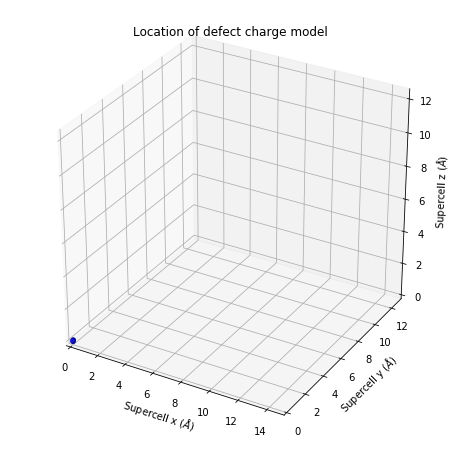

In [21]:
# TEST CELL FOR PLOTTING 3D GAUSSIAN CHARGE MODEL IN SUPERCELL
#############################################

# Approximate Gaussian charge model to sphere with radius of sigma


%matplotlib inline
from mpl_toolkits import mplot3d
from IPython.core.pylabtools import figsize
figsize(8, 8)



#fig = plt.figure()
#ax = plt.axes(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = sigma * np.outer(np.cos(u), np.sin(v))
y = sigma * np.outer(np.sin(u), np.sin(v))
z = sigma * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, color='b')



ax.set_xlim3d(0,supercell_dims[0])
ax.set_ylim3d(0,supercell_dims[1])
ax.set_zlim3d(0,supercell_dims[2])
ax.set_xlabel('Supercell x ($\AA$)')
ax.set_ylabel('Supercell y ($\AA$)')
ax.set_zlabel('Supercell z ($\AA$)')
plt.title('Location of defect charge model')

plt.show()


## 6. Generate 'in' file for charge model calculation with coffee.py

In [12]:
### Writing 'in' file for coffee.py
coffee_in = open("in", "w")

## CELL PARAMS
coffee_in.write("&CELL_PARAMETERS\n")
coffee_in.write("\n")
coffee_in.write("Lattice_Vectors(normalized):\n")
# Read in lattice vectors from geometry.in, normalize and write to 'in' file for CoFFEE
x_vecs, y_vecs, z_vecs = read_lattice_vectors(defect_geom)
a1_tot = x_vecs[0]+y_vecs[0]+z_vecs[0]
a2_tot = x_vecs[1]+y_vecs[1]+z_vecs[1]
a3_tot = x_vecs[2]+y_vecs[2]+z_vecs[2]
coffee_in.write(str(x_vecs[0]/a1_tot)+"   "+str(y_vecs[0]/a1_tot)+"   "+str(z_vecs[0]/a1_tot)+"\n")
coffee_in.write(str(x_vecs[1]/a2_tot)+"   "+str(y_vecs[1]/a2_tot)+"   "+str(z_vecs[1]/a2_tot)+"\n")
coffee_in.write(str(x_vecs[2]/a3_tot)+"   "+str(y_vecs[2]/a3_tot)+"   "+str(z_vecs[2]/a3_tot)+"\n")
coffee_in.write("\n")
coffee_in.write("Cell_dimensions angstrom\n")
coffee_in.write(str(a1_tot)+"  "+str(a2_tot)+"   "+str(a3_tot)+"\n")
coffee_in.write("\n")
coffee_in.write("Ecut="+str(cutoff)+" Hartree\n")
coffee_in.write("/\n")
coffee_in.write("\n")

## DIELECTRIC PARAMS
coffee_in.write("&DIELECTRIC_PARAMETERS Bulk\n")
coffee_in.write("Epsilon1_a1 = "+str(dielectric_xx)+"\n")
coffee_in.write("Epsilon1_a2 = "+str(dielectric_yy)+"\n")
coffee_in.write("Epsilon1_a3 = "+str(dielectric_zz)+"\n")
coffee_in.write("/\n")
coffee_in.write("\n")

## GAUSSIAN PARAMS (used for charge model)
coffee_in.write("&GAUSSIAN_PARAMETERS:\n")
coffee_in.write("Total_charge = "+str(defect_charge)+"\n")
coffee_in.write("Sigma = "+str(sigma)+"\n")
# Centre of Gaussian is set as defect location
coffee_in.write("Centre_a1 = "+str(defect_x/a1_tot)+"\n") # CHECK THIS IS CORRECT! (in crystal units?!)
coffee_in.write("Centre_a2 = "+str(defect_y/a2_tot)+"\n")
coffee_in.write("Centre_a3 = "+str(defect_z/a3_tot)+"\n")
coffee_in.write("/\n")
coffee_in.close()

## 7. Run CoFFEE

### 7a. Obtain E_lat for the charge model
See the [CoFFEE paper](https://www.sciencedirect.com/science/article/pii/S0010465518300158) for details.

In [13]:
# MUST ACTIVATE COFFEE ENV TO RUN THIS (need to reinstall with python3)

#os.system("./"+str(path_to_coffee_dir)+"/coffee.py in > "+str(charge_model_file))
try:
    subprocess.check_output(str(path_to_coffee_dir)+"/coffee.py in > "+str(charge_model_file), shell=True, stderr=subprocess.STDOUT)
except Exception as err:
    print(err.output)
    
    
    

# Do python re equivalent of below to get E_q^per,m from output
# grep ! ${charge_model_file}

# Use fit for extrapolation to get obtain E_q^iso,m
# python plot_fit.py  # In CoFFEE ModelCharge/Utilities dir??
# /Users/suzy/Desktop/DefectAnalysis/CoFFEE_1.1/Examples/3D/Diamond/Model_Scaling/plot_fit.py

# Obtain E_lat = E_q^iso,m - E_q^per,m


### 7b. Obtain planar average of the potential of the charge model
Outputs from step 7a are used to obtain the planar average of potential for charge model from CoFFEE. This is needed for the potential alignment step. 

The script below uses V_r.npy generated from step6 with in_V to obtain plavg_a3.plot ????? - check CoFFEE docs

In [ ]:
# See pg 14 of CoFFEE user guide
# use V_r.npy from coffee.py output with path_to_coffee_folder/PotentialAlignment/Utilities/plavg.py in_V
# This will create a file plavg_a1.plot for charge model to use for pa step with Tong's script




## 8. Perform potential alignment (pa)
Use plavg_a3.plot for the planar average of the charge model obtained in step 6 from CoFFEE with 'plane_average_realspace_ESP.out' files from FHI-aims calculation for the perfect host, neutral defect and charged defect.

With thanks to Tong Zhu for the original plotting script the one below is based on.

In [ ]:
%matplotlib inline

### USER INPUTS ### -- update to refer to relevant directories specified at the top of the notebook
host_pot = 
neutral_defect_pot = 
charged_defect_pot =
###################


"""
Created on Wed Oct 24 13:11:47 2018

@author: tong

For correction  only V_0- V_Host  
The usage should be:  plot.py charge lattice_constant_z defect_pos_z  Host_potential_filename  defect_neutral_potential_filename 
charge:  defect charges 
lattice_constant_z:  z-direction lattice_constant 
defect_pos_z:  defect_position at z-direction 
e.g.   plot.py  -1 18.52  4.59  origin_plane_averge_esp.out  m0_plane_averge_esp.out  



For the whole correction by CoFFEE, i.e. two terms picture  q(V_0 - V_host) and  q((V_charge-V_0) - V_model)

The usage should be: plot.py charge lattice_constant_z defect_pos_z  Host_potential_filename  defect_neutral_potential_filename defect_charge_potential_filename  defect_model_potential_filename  

"""



#unit conversion  
Ha_eV = 27.2116   # hartree to eV
b_A = 0.529177249  # bohr to angstrom 

def read_file(Filename):  
    # reading the plane-average-file from FHI-aims output, 
    #and obtain the free-average-contribution, and the raw data 
    F = open(Filename, "r")
    res = F.readline().split()
    dim=len(res)
    average_free = float(res[dim-1])
    F.readline()
    F.readline()
    data = F.readlines()
    dim = len(data)
    result  = np.zeros([dim,2])
    i = 0 
    for line in data:
      words = line.split()
      result[i][0] = float(words[0])
      result[i][1] = float(words[1])
      i=i+1
    return average_free, result 

dim_sys = len(sys.argv)
charge = float(sys.argv[1])
lattice_constant_z = float(sys.argv[2])
Defect_pos = float(sys.argv[3])
Origin_F=sys.argv[4]
Defect_neutral_F=sys.argv[5]
if dim_sys > 6: 
   Defect_charge_F=sys.argv[6] 
   Defect_model_F = sys.argv[7]


offset_o, origin = read_file(Origin_F)
offset_d, defect_neutral = read_file(Defect_neutral_F)


X = defect_neutral[:,0]
Y = charge*(defect_neutral[:,1]*Ha_eV - offset_d - (origin[:,1]*Ha_eV-offset_o)) 

print charge 
print lattice_constant_z

#begin ploting q*(V(Defect,0) - V(Host))
Y_min = min(Y)
Y_max = max(Y)
Ymin = Y_min - 0.15*(Y_max-Y_min)
Ymax = Y_max + 0.15*(Y_max-Y_min)
plt.xlim((0,lattice_constant_z))
plt.ylim((Ymin,Ymax))
plt.axvline(x=Defect_pos,linestyle='--',color='orange')
plt.plot(X,Y,'or',label='q(V(Defect,0)-V(Host))')
plt.legend()
plt.xlabel(r'Z-coordinates ($\AA$)',fontsize=15,fontname = "Times New Roman")
plt.ylabel('Potential (eV)',fontsize=15,fontname = "Times New Roman")
plt.savefig("V0-Vhost",dpi=600)

#begin plot    V(Defect,charge) - V(Defect,0) and   V_Model 
if dim_sys > 6:
   offset_d2, defect_charge = read_file(Defect_charge_F)
   Model = np.loadtxt(Defect_model_F)
   X1 = defect_charge[:,0]
   Y1 = defect_charge[:,1]*Ha_eV-offset_d2 - (defect_neutral[:,1]*Ha_eV-offset_d)
   X_model = Model[:,0]*b_A
   Y_model = Model[:,1]*-1.0  

   Y_min = min(Y_model)
   Y_max = max(Y_model)
   Ymin = Y_min - 0.15*(Y_max-Y_min)
   Ymax = Y_max + 0.15*(Y_max-Y_min)


   plt.clf()
   plt.xlim((0,lattice_constant_z))
   plt.ylim((Ymin,Ymax))
   plt.axvline(x=Defect_pos,linestyle='--',color='orange')
   plt.plot(X1,Y1,'or',label='V(Defect,q)-V(Defect,0)')
   plt.plot(X_model,Y_model,'--k',label='V(Model)')
   plt.legend()
   plt.xlabel(r'Z-coordinates ($\AA$)',fontsize=15,fontname = "Times New Roman")
   plt.ylabel('Potential (eV)',fontsize=15,fontname = "Times New Roman")
   plt.savefig("V_charge-V0",dpi=600)
